# ANS Data Analysis Notebook
### *All code can be found at my [Github](https://github.com/EthanS47/cognitive_tests_23136637)*
### ___________________________________________________________________________________________

In [175]:
# Importing libraries
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import wilcoxon

# THINGS TO ADD
# Section headings (markdown cells) to structure the report, comments
# Analysis section looking at if there is a significant difference time difference between ratios of larger vs smaller
# Maybe find another analysis could do for age?
# Find equations for the trend lines and see if there is a way to infer significance or lack thereof

# ________________________________________________________________
## Reading & Manipulating Data into Dataframes

In [227]:
### Reading & Manipulating Data into Dataframes ###
# Read in excel sheets as data frame
# All excel sheets labeled 2 are for slower ANS test
df = pd.read_excel("C:/Users/elshe/Desktop/ANS_Answers.xlsx", header=0)
df2 = pd.read_excel("C:/Users/elshe/Desktop/ANS_Answers2.xlsx", header=0)
ratiosdf = pd.read_excel("C:/Users/elshe/Desktop/ratioexcel.xlsx", header=0)
ratiosdf2 = pd.read_excel("C:/Users/elshe/Desktop/ratioexcel2.xlsx", header=0)
timesdf = pd.read_excel("C:/Users/elshe/Desktop/timesexcel.xlsx", header=0, index_col=0)
timesdf2 = pd.read_excel("C:/Users/elshe/Desktop/timesexcel2.xlsx", header=0, index_col=0)
extrasdf = pd.read_excel("C:/Users/elshe/Desktop/extrasexcel.xlsx", header=1)
questiontimedf = pd.read_excel("C:/Users/elshe/Desktop/questiontimeexcel.xlsx", header=0, index_col=0)
questiontimedf2 = pd.read_excel("C:/Users/elshe/Desktop/questiontimeexcel2.xlsx", header=0, index_col=0)

# Defining user_ids in ordered list
user_ids = ['JSEM', 'MQXZ', 'qwer', 'kdif', 'CENK', 'MARC', 'EMST', 'STEL', 'MATA', 'JINE', 'IUDF', 'CYNT', 'ANDR',
           'NIKR', 'KEEN', 'GRAC', 'JSOP', 'RIVE', 'LCIB', 'YDIF']


# Simplify's the questions ratio of dots to simplest form
def simplify_ratio(ratio_string):
    # Split the string into two numbers
    num1, num2 = map(int, ratio_string.split('_'))
    
    # Find the greatest common divisor
    gcd = math.gcd(num1, num2)
    
    # Simplify the ratio
    simplified_num1 = num1 // gcd
    simplified_num2 = num2 // gcd
    
    # Ensure the smaller number is first
    if simplified_num1 > simplified_num2:
        simplified_num1, simplified_num2 = simplified_num2, simplified_num1

    # Return the simplified ratio as a string
    return f"{simplified_num1}_{simplified_num2}"

#### Creating Dataframe for each individual's Pe values ####
### Creating function to find Pe's for each user ###
# Creating list to store simplified ratios
def pe_dataframes(ratiosdf):
    simplified_ratios = []
    # Looping through rows of df to simplify ratios using simplify_ratio function
    for ratio in ratiosdf.iloc[:, 0]:
        simplified_ratios.append(simplify_ratio(ratio))

    # Creating df of simplified ratios and answers
    simplifiedratiosdf = pd.DataFrame()
    simplifiedratiosdf['ratios'] = simplified_ratios

    for column in user_ids:
        simplifiedratiosdf[column] = ratiosdf[column]


    # Loop through each ratio
    # AI Assisted
    results = []
    for ratio, group in simplifiedratiosdf.groupby('ratios'):
        # Calculate correctness percentage for each user
        for user in simplifiedratiosdf.columns[1:]:
            correct_percentage = 1 - (group[user].sum() / len(group[user]))
            results.append({'Ratio': ratio, 'User': user, 'Correct Percentage': correct_percentage})

    # Create a DataFrame from the results list
    temp_df = pd.DataFrame(results)

    # Pivot the DataFrame to get the desired format
    pe_df = temp_df.pivot(index='Ratio', columns='User', values='Correct Percentage')
    return pe_df

pe_df = pe_dataframes(ratiosdf)
pe_df2 = pe_dataframes(ratiosdf2)

# ________________________________________________________________
## Weber Fraction Calculation

In [241]:
# Creating dots ratio & weber fraction list
r_list = [3/4, 6/7, 8/9, 9/10, 4/5, 5/6, 6/8, 7/8]

### Define function to calculate Pe ###
# Used to calculate the predicted values of pe for the models
def calculate_pe(r, w):
    # Calculating x for the math.erfc() function using part of the Probability Error equation
    x = (1 / w) * np.sqrt(0.5) * (1 - r) / np.sqrt(1 + r**2)
    # Calculating the probability error and returning it
    pe = 0.5 * math.erfc(x)
    return pe

### Defining get_w function ###
# Used to find the best fit w
# Input lists of ratios used and individual's Pe for each ratio
# AI Assisted
def get_w(ratios, Pe):
    # Initializing the best 'w' and minimum sum of squared residuals
    best_w = 0
    min_SSR = float('inf')
    
    # Iterating over possible w values from 0.01 to 1 in steps of 0.01 (start from 0.0001 to avoid dividing by zero)
    for w in np.arange(0.0001, 1.01, 0.01):
        # Calculating SSR for this 'w' value
        SSR = sum((Pe[i] - calculate_pe(ratios[i], w))**2 for i in range(len(ratios)-1))
        
        # Checking if this SSR is smaller than smallest SSR found so far and updating if variables if is
        if SSR < min_SSR:
            min_SSR = SSR
            best_w = w
    # Returning the 'w' that resulted in the smallest SSR
    return best_w


# Creating loop to get weber fraction for each user
### Defining function to loop through df to get all user's weber fractions
def get_all_w(pe_df):
    # Storing user weber fractions in list
    w_list = []
    # Loop through each column in the DataFrame and apply the function
    for user_id in user_ids:
        if user_id in pe_df.columns:
            column_data = pe_df[user_id]
            result = get_w(r_list, column_data)
            w_list.append(result)
    return w_list

# Creating a dataframe for User's fast weber fraction values
w_df = pd.DataFrame()
w_df['user_id'] = df['user_id']
w_list = get_all_w(pe_df)
w_df['w'] = w_list

# Creating a dataframe for User's slow weber fraction values
w_df2 = pd.DataFrame()
w_df2['user_id'] = df['user_id']
w_list2 = get_all_w(pe_df2)
w_df['w'] = w_list

C:\Users\elshe\AppData\Local\Temp\ipykernel_15352\2760110539.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  SSR = sum((Pe[i] - calculate_pe(ratios[i], w))**2 for i in range(len(ratios)-1))
C:\Users\elshe\AppData\Local\Temp\ipykernel_15352\2760110539.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  SSR = sum((Pe[i] - calculate_pe(ratios[i], w))**2 for i in range(len(ratios)-1))


In [228]:
### Wilcoxon Signed-Rank Test on Weber Fractions ###
stat, p = wilcoxon(w_df['w'], w_df2['w'])

print("Wilcoxon Test for Weber fraction between slow and fast tests")
print(f"Test Statistic: {stat}, p-Value: {p}")

### Wilcoxon Signed-Rank Test on total_times
stat, p = wilcoxon(timesdf['total_time'], timesdf2['total_time'])
print("Wilcoxon Test for Total time between slow and fast tests")
print(f"Test Statistic: {stat}, p-Value: {p}")

Wilcoxon Test for Weber fraction between slow and fast tests
Test Statistic: 14.0, p-Value: 0.015398453529599815
Wilcoxon Test for Total time between slow and fast tests
Test Statistic: 18.0, p-Value: 0.0004825592041015625


C:\Users\elshe\anaconda3\lib\site-packages\scipy\stats\_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


## ____________________________________________________________________________
## Box Plot of Weber fraction Vs. Education Level

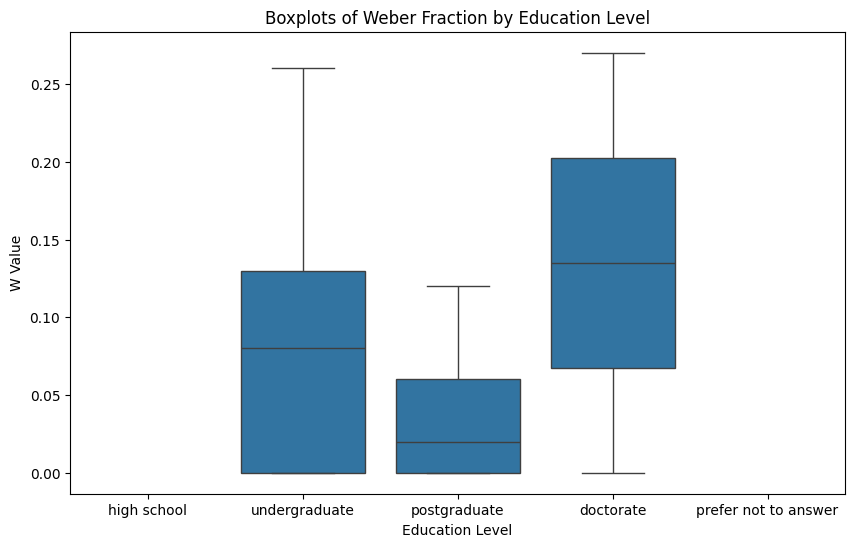

In [178]:
# Adding weber fraction values to extrasdf as column
extrasdf['w'] = w_list
# Defining the order of the education levels
education_order = ['high school', 'undergraduate', 'postgraduate', 'doctorate', 'prefer not to answer']
# Create the boxplots
plt.figure(figsize=(10, 6))
sns.boxplot(x='education', y='w', data=extrasdf, order=education_order)

# Set the plot title and labels
plt.title('Boxplots of Weber Fraction by Education Level')
plt.xlabel('Education Level')
plt.ylabel('W Value')

# Show the plot
plt.show()

## ___________________________________________________________________________
## Box Plot of Weber fraction Vs. Maths Level ###

C:\Users\elshe\AppData\Local\Temp\ipykernel_15352\3732277452.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=6)


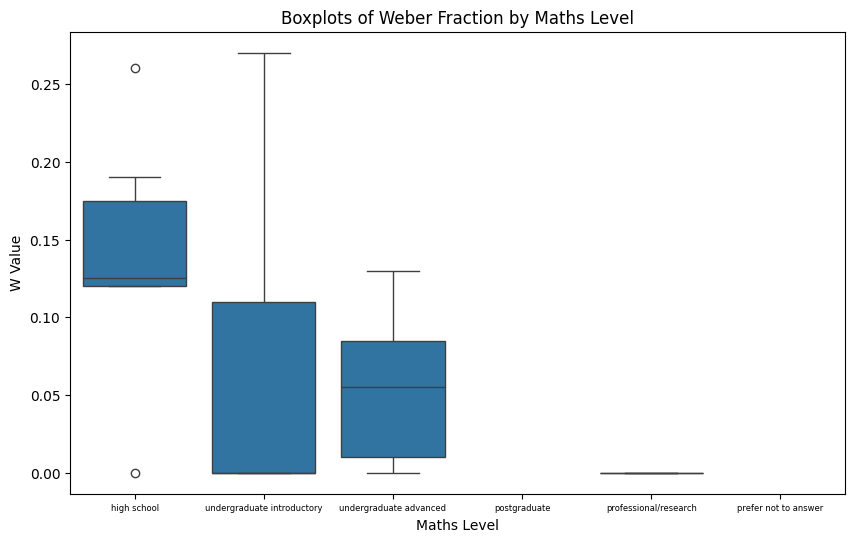

In [179]:
# Adding weber fraction values to extrasdf as column
extrasdf['w'] = w_list

# Defining the order of maths level
maths_order = ['high school', 'undergraduate introductory', 'undergraduate advanced', 'postgraduate', 'professional/research',
              'prefer not to answer']

# Create the boxplots
plt.figure(figsize=(10, 6))
ax = sns.boxplot(x='ms', y='w', data=extrasdf, order=maths_order)

ax.set_xticklabels(ax.get_xticklabels(), fontsize=6)

# Set the plot title and labels
plt.title('Boxplots of Weber Fraction by Maths Level')
plt.xlabel('Maths Level')
plt.ylabel('W Value')

# Show the plot
plt.show()

## ___________________________________________________________________________
## Weber fraction Vs. Response Time

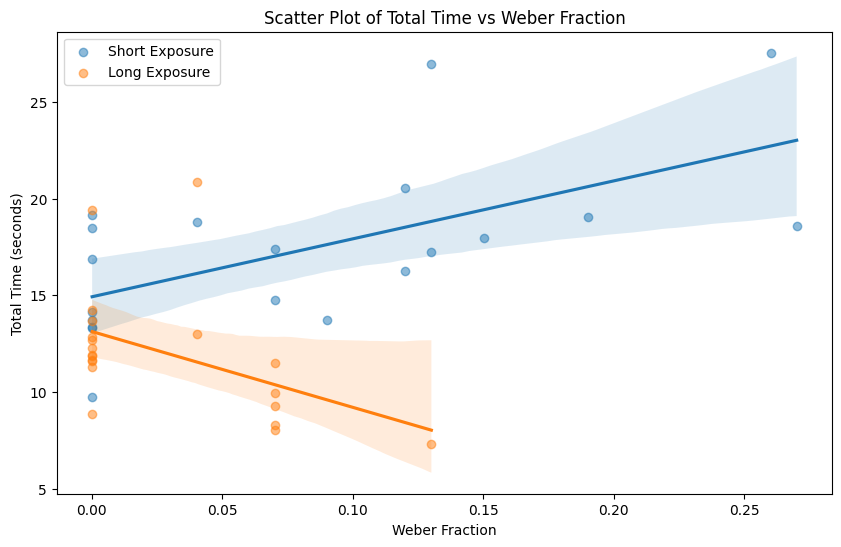

In [253]:
# Adding weber fraction & age values to timesdf & timesdf2 as column
timesdf['w'] = w_list
timesdf2['w'] = w_list2
age_list = extrasdf['age'].tolist()
timesdf['age'] = age_list
timesdf2['age'] = age_list

# Create a scatter plot with a trend line
plt.figure(figsize=(10, 6))
sns.regplot(x='w', y='total_time', data=timesdf, scatter_kws={'alpha':0.5}, label='Short Exposure')
sns.regplot(x='w', y='total_time', data=timesdf2, scatter_kws={'alpha':0.5}, label='Long Exposure')

# Setting plot labels
plt.title('Scatter Plot of Total Time vs Weber Fraction')
plt.xlabel('Weber Fraction')
plt.ylabel('Total Time (seconds)')

#Display legend
plt.legend()

# Show the plot
plt.show()

### Analysis of Weber fraction Vs. Total Response time Linear Regression Model

In [254]:
# Create simplified function to find regression model and trend line equation
def regression_model(X, Y):
    X = sm.add_constant(X)  # Adds a constant term to the predictor

    # Fit the regression model
    model = sm.OLS(Y, X).fit()

    # Get the trend line equation parameters
    slope, intercept = model.params

    print(f"The equation of the trend line is: Y = {slope:.2f}X + {intercept:.2f}")
    print(model.summary())
    return

# Finding the regression model and trend line of total response time vs weber fraction
# Short exposure regression model
regression_model(timesdf['w'], timesdf['total_time'])
# === Prob (F-statistic) = 0.00419 indicates model is significant assuming sig level of 0.05
# Long exposure regression model
regression_model(timesdf2['w'], timesdf2['total_time'])
# === Prob (F-statistic) = 0.0451 indicates model is significant assuming sig level of 0.05

The equation of the trend line is: Y = 14.92X + 29.97
                            OLS Regression Results                            
Dep. Variable:             total_time   R-squared:                       0.374
Model:                            OLS   Adj. R-squared:                  0.339
Method:                 Least Squares   F-statistic:                     10.73
Date:                Mon, 19 Feb 2024   Prob (F-statistic):            0.00419
Time:                        01:39:16   Log-Likelihood:                -52.400
No. Observations:                  20   AIC:                             108.8
Df Residuals:                      18   BIC:                             110.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

## ___________________________________________________________________________
## Scatterplot of Weber fraction Vs. Age

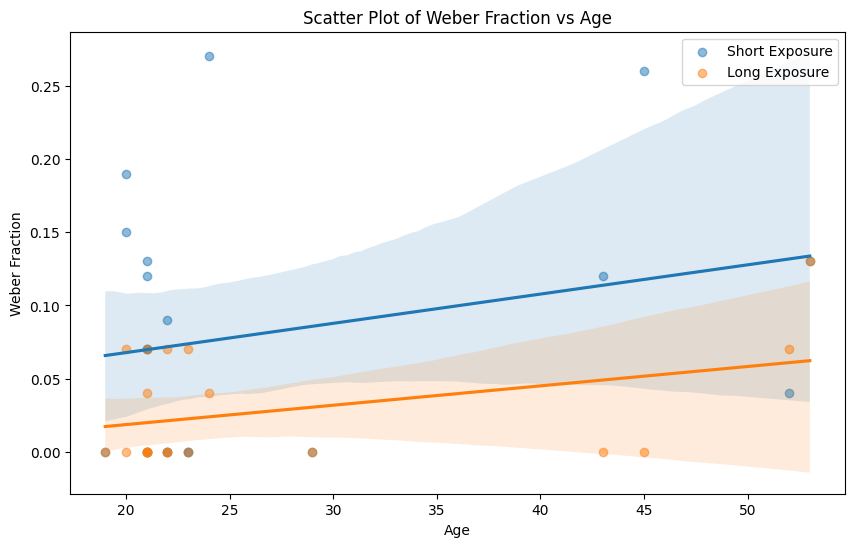

In [255]:
# Create a scatter plot with a trend line
plt.figure(figsize=(10, 6))
sns.regplot(x='age', y='w', data=timesdf, scatter_kws={'alpha':0.5}, label='Short Exposure')
sns.regplot(x='age', y='w', data=timesdf2, scatter_kws={'alpha':0.5}, label='Long Exposure')

# Setting plot labels
plt.title('Scatter Plot of Weber Fraction vs Age')
plt.xlabel('Age')
plt.ylabel('Weber Fraction')

# Display legend
plt.legend()

# Show the plot
plt.show()

### Analysis of Weber fraction vs Age Linear Regression Model

In [256]:
# Finding the regression model and trend line of weber fraction vs age
# Short exposure regression model
regression_model(timesdf['age'], timesdf['w'])
# === Prob (F-statistic) = 0.279 indicates model is not significant assuming sig level of 0.05
# Long exposure regression model
regression_model(timesdf2['age'], timesdf2['w'])
# === Prob (F-statistic) = 0.0991 indicates model is not significant assuming sig level of 0.05

The equation of the trend line is: Y = 0.03X + 0.00
                            OLS Regression Results                            
Dep. Variable:                      w   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     1.246
Date:                Mon, 19 Feb 2024   Prob (F-statistic):              0.279
Time:                        01:39:55   Log-Likelihood:                 21.440
No. Observations:                  20   AIC:                            -38.88
Df Residuals:                      18   BIC:                            -36.89
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------


## ___________________________________________________________________________
## Scatterplot of Total response time Vs. Age

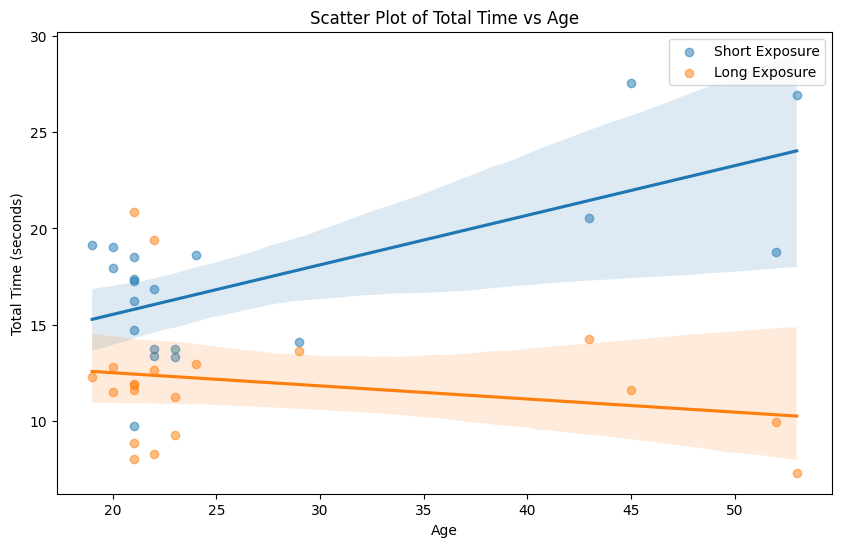

In [258]:
#### Response Time Analysis ####
# Merging extrasdf columns with timesdf
timesdf = timesdf.drop('age', axis=1, errors='ignore')
timesdf = timesdf.merge(extrasdf[['user_id', 'age']], on='user_id', how='left')

# Create a scatter plot with a trend line
plt.figure(figsize=(10, 6))
sns.regplot(x='age', y='total_time', data=timesdf, scatter_kws={'alpha':0.5}, label='Short Exposure')
sns.regplot(x='age', y='total_time', data=timesdf2, scatter_kws={'alpha':0.5}, label='Long Exposure')

# Labeling the plot
plt.title('Scatter Plot of Total Time vs Age')
plt.xlabel('Age')
plt.ylabel('Total Time (seconds)')

# Display legend
plt.legend()

# Show the plot
plt.show()

### Analysis of Total response time Vs. Age Linear Regression Model

In [257]:
# Finding the regression model and trend line of total response time vs age
# Short exposure regression model
regression_model(timesdf['age'], timesdf['total_time'])
# === Prob (F-statistic) = 0.00128 indicates model is significant assuming sig level of 0.05
# Long exposure regression model
regression_model(timesdf2['age'], timesdf2['total_time'])
# === Prob (F-statistic) = 0.339 indicates model is not significant assuming sig level of 0.05

The equation of the trend line is: Y = 10.39X + 0.26
                            OLS Regression Results                            
Dep. Variable:             total_time   R-squared:                       0.446
Model:                            OLS   Adj. R-squared:                  0.416
Method:                 Least Squares   F-statistic:                     14.52
Date:                Mon, 19 Feb 2024   Prob (F-statistic):            0.00128
Time:                        01:41:58   Log-Likelihood:                -51.163
No. Observations:                  20   AIC:                             106.3
Df Residuals:                      18   BIC:                             108.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------